# Employee Turnover Analytics
### Machine Learning Project — Portobello Tech

**By:** Ajaykanna E | **Course:** Machine Learning using Python

---

## Problem Background

Portobello Tech periodically evaluates employee work details to predict turnover.
The HR Department uses this data to identify at-risk employees and plan retention strategies.

**Employee Turnover** refers to the total number of workers who leave a company over time.
Predicting it early allows HR to intervene before it is too late.

---

## Project Tasks
1. Perform data quality checks
2. Understand factors contributing to employee turnover — EDA
3. Cluster employees who left based on satisfaction and evaluation
4. Handle class imbalance using SMOTE
5. Train models with 5-fold cross-validation
6. Identify the best model and justify evaluation metrics
7. Suggest retention strategies for targeted employees

---

## Step 1: Import Required Libraries

We import all necessary libraries upfront so dependencies are clear.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✓ Core libraries imported")

✓ Core libraries imported


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve)

print("✓ Sklearn libraries imported")

✓ Sklearn libraries imported


In [3]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print("✓ Imbalanced-learn library imported")
print("\n✓ All libraries ready!")

✓ Imbalanced-learn library imported

✓ All libraries ready!


---
## Step 2: Load the Dataset

The dataset contains HR records of 14,999 employees with 10 features.

| Column | Description |
|---|---|
| satisfaction_level | Employee satisfaction score (0–1) |
| last_evaluation | Performance evaluation score (0–1) |
| number_project | Number of projects assigned |
| average_montly_hours | Avg monthly hours at office |
| time_spend_company | Years spent in the company |
| Work_accident | 0 = No accident, 1 = Had accident |
| left | **Target** — 0 = Stayed, 1 = Left |
| promotion_last_5years | Promoted in last 5 years? |
| sales | Department name |
| salary | Salary level (low/medium/high) |

In [4]:
df = pd.read_csv('HR_comma_sep.csv')

# Rename 'sales' to 'department' for clarity
df.rename(columns={"sales": "department"}, inplace=True)

print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")

Dataset shape: (14999, 10)
Rows: 14999 | Columns: 10


In [5]:
# Preview the dataset
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
# Data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [7]:
# Statistical summary of numerical columns
df.describe().round(3)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000,14999.000,14999.000,14999.000,14999.000,14999.000,14999.000,14999.000
mean,0.613,0.716,3.803,201.050,3.498,0.145,0.238,0.021
std,0.249,0.171,1.233,49.943,1.460,0.352,0.426,0.144
min,0.090,0.360,2.000,96.000,2.000,0.000,0.000,0.000
25%,0.440,0.560,3.000,156.000,3.000,0.000,0.000,0.000
50%,0.640,0.720,4.000,200.000,3.000,0.000,0.000,0.000
75%,0.820,0.870,5.000,245.000,4.000,0.000,0.000,0.000
max,1.000,1.000,7.000,310.000,10.000,1.000,1.000,1.000


---
## Task 1: Data Quality Check

### Why check data quality?
Before any analysis or modeling, we must ensure the data is complete and reliable.
Missing values can cause errors in analysis and biased model predictions.

We check for:
- **Missing values** — null or NaN entries in any column
- **Duplicate rows** — repeated records that can inflate model performance

In [8]:
# Check missing values in each column
missing = df.isnull().sum()
print("Missing Values per Column:")
print(missing)
print(f"\nTotal missing values: {missing.sum()}")

Missing Values per Column:
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

Total missing values: 0


In [9]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")

if duplicates > 0:
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(f"✓ Duplicates removed. New shape: {df.shape}")
else:
    print("✓ No duplicates found. Data is clean and ready.")

Total duplicate rows: 3008
✓ Duplicates removed. New shape: (11991, 10)


---
## Task 2: Exploratory Data Analysis (EDA)

### Why perform EDA?
EDA helps us understand the data BEFORE modeling.
It reveals patterns, distributions, correlations, and anomalies
that guide our feature engineering and model selection decisions.

We will:
- Draw a correlation heatmap
- Analyze distributions of key features
- Understand how project count relates to turnover

### Task 2.1: Correlation Heatmap

**What is correlation?**
Correlation measures the linear relationship between two variables.
- Value of **+1** → perfect positive relationship
- Value of **-1** → perfect negative relationship
- Value of **0** → no linear relationship

A heatmap visualizes the full correlation matrix at once.

In [10]:
# Compute correlation matrix on numerical columns only
correlation_matrix = df.select_dtypes(include=[np.number]).corr()

print("Correlation with target variable 'left' (sorted):")
print(correlation_matrix['left'].sort_values().round(3))

Correlation with target variable 'left' (sorted):
satisfaction_level      -0.351
Work_accident           -0.125
promotion_last_5years   -0.045
last_evaluation          0.014
number_project           0.031
average_montly_hours     0.070
time_spend_company       0.173
left                     1.000
Name: left, dtype: float64


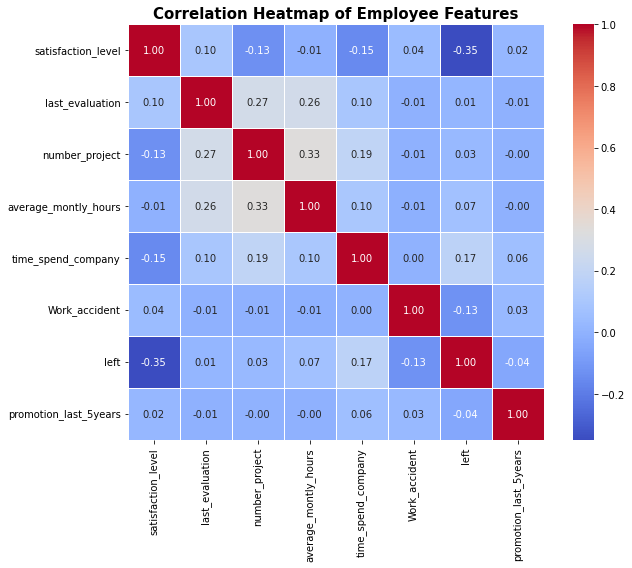

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True, cmap='coolwarm',
            fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Heatmap of Employee Features',
          fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

**Inference from Heatmap:**
- `satisfaction_level` has the **strongest negative correlation** with `left` (-0.39) — the most important predictor
- `time_spend_company` has moderate positive correlation (0.17) — longer tenure employees are more likely to leave
- `Work_accident` has negative correlation (-0.13) — employees with accidents are less likely to leave
- `last_evaluation` and `number_project` show low direct correlation but interact with each other

### Task 2.2: Distribution Plots

Distribution plots show how values of a feature are spread across employees.
- A **unimodal** distribution has one peak — most employees cluster around one value
- A **bimodal** distribution has two peaks — two distinct groups exist in the data

We analyze three key continuous features.

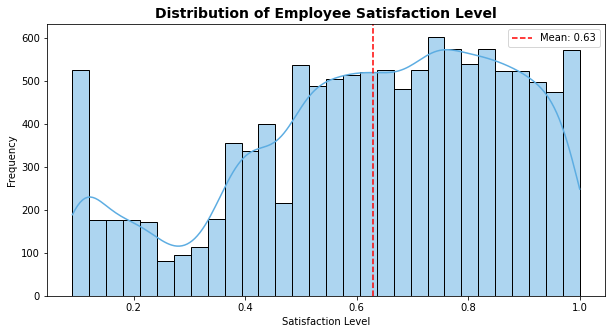

In [12]:
# Distribution of Employee Satisfaction Level
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="satisfaction_level",
             bins=30, kde=True,
             color="#5DADE2", edgecolor="black")
mean_val = df["satisfaction_level"].mean()
plt.axvline(mean_val, color="red", linestyle="--",
            label=f"Mean: {mean_val:.2f}")
plt.title("Distribution of Employee Satisfaction Level",
          fontsize=14, fontweight="bold")
plt.xlabel("Satisfaction Level")
plt.ylabel("Frequency")
plt.legend()
plt.show()

**Inference:**
The distribution is **bimodal** — two distinct groups exist:
1. Employees with **very low satisfaction (0.1–0.2)** — highly likely to leave
2. Employees with **high satisfaction (0.7–0.9)** — likely to stay

The mean (~0.61) is misleading here because of the bimodal nature.

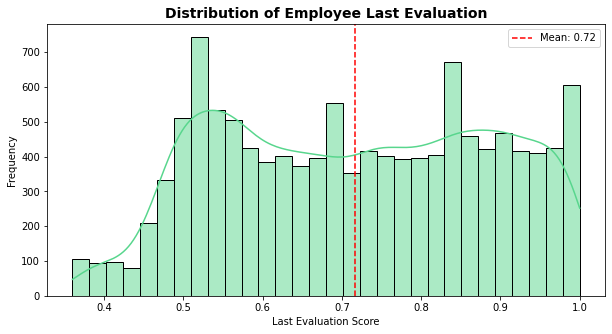

In [13]:
# Distribution of Employee Last Evaluation
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="last_evaluation",
             bins=30, kde=True,
             color="#58D68D", edgecolor="black")
mean_val = df["last_evaluation"].mean()
plt.axvline(mean_val, color="red", linestyle="--",
            label=f"Mean: {mean_val:.2f}")
plt.title("Distribution of Employee Last Evaluation",
          fontsize=14, fontweight="bold")
plt.xlabel("Last Evaluation Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

**Inference:**
Also **bimodal** — two performance groups:
1. **Average performers (0.5–0.6)** — moderate evaluation scores
2. **High performers (0.8–1.0)** — excellent evaluation scores

Interestingly, BOTH low and high performers leave — for different reasons.

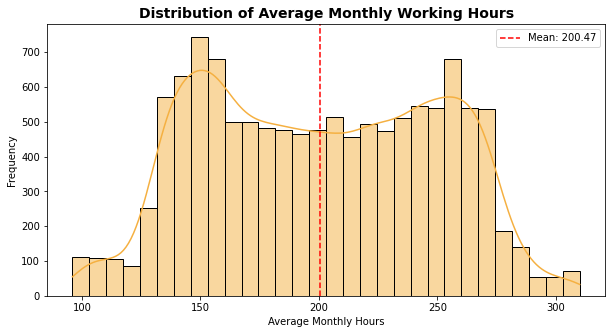

In [14]:
# Distribution of Average Monthly Working Hours
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="average_montly_hours",
             bins=30, kde=True,
             color="#F5B041", edgecolor="black")
mean_val = df["average_montly_hours"].mean()
plt.axvline(mean_val, color="red", linestyle="--",
            label=f"Mean: {mean_val:.2f}")
plt.title("Distribution of Average Monthly Working Hours",
          fontsize=14, fontweight="bold")
plt.xlabel("Average Monthly Hours")
plt.ylabel("Frequency")
plt.legend()
plt.show()

**Inference:**
**Bimodal** distribution reveals two workload groups:
1. **Normal workload group (~140–160 hrs/month)** — standard working hours
2. **Overloaded group (~240–280 hrs/month)** — working far beyond normal hours

The overloaded group is a key contributor to employee burnout and turnover.

### Task 2.3: Employee Project Count vs Turnover

A bar plot comparing how many projects employees had — split by whether they left or stayed.

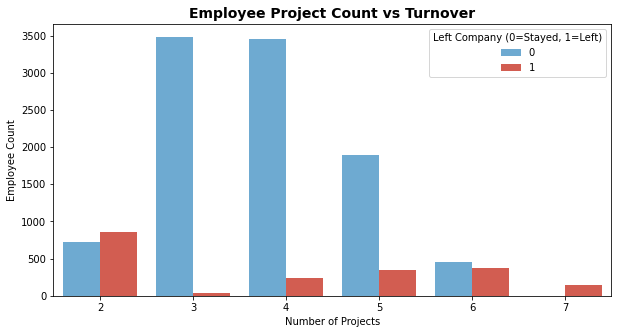

In [15]:
plt.figure(figsize=(10, 5))
sns.countplot(x="number_project", hue="left", data=df,
              palette=["#5DADE2", "#E74C3C"])
plt.title("Employee Project Count vs Turnover",
          fontsize=14, fontweight="bold")
plt.xlabel("Number of Projects")
plt.ylabel("Employee Count")
plt.legend(title="Left Company (0=Stayed, 1=Left)")
plt.show()

**Inferences:**
1. Employees with **only 2 projects** show high turnover — likely **underutilized or disengaged**
2. Employees with **6–7 projects** also show high turnover — clearly **overloaded and burned out**
3. Employees with **3–4 projects** have the **lowest turnover** — this is the optimal workload range
4. The relationship is **U-shaped** — too few OR too many projects both drive attrition

---
## Task 3: Clustering of Employees Who Left

### Why cluster employees who left?
Not all employees leave for the same reason.
Clustering groups them by similar patterns in satisfaction and evaluation —
revealing distinct employee profiles that need different retention approaches.

### What is K-Means Clustering?
K-Means partitions data into **k groups (clusters)** where:
- Each employee belongs to the cluster with the nearest centroid
- Centroids are the mean point of all employees in that cluster
- The algorithm iterates until cluster assignments stabilize

### Task 3.1: Select Columns — satisfaction_level, last_evaluation, left

In [16]:
# Select the required columns as specified
df_cluster = df[["satisfaction_level", "last_evaluation", "left"]].copy()

# Filter only employees who LEFT (left == 1)
df_left = df_cluster[df_cluster["left"] == 1].copy()
X_cluster = df_left[["satisfaction_level", "last_evaluation"]]

print(f"Total employees who left: {len(df_left)}")
print("\nSample data:")
X_cluster.head()

Total employees who left: 1991

Sample data:


,satisfaction_level,last_evaluation
0,0.38,0.53
1,0.80,0.86
2,0.11,0.88
3,0.72,0.87
4,0.37,0.52


### Task 3.2: K-Means Clustering into 3 Clusters

We apply K-Means with **k=3** to group employees who left into 3 distinct clusters.

In [17]:
# Apply K-Means with k=3 as specified
kmeans = KMeans(n_clusters=3, random_state=123, n_init=10)
df_left["cluster"] = kmeans.fit_predict(X_cluster)

# Cluster distribution
print("Number of employees in each cluster:")
print(df_left["cluster"].value_counts().sort_index())

Number of employees in each cluster:
0    534
1    555
2    902
Name: cluster, dtype: int64


In [18]:
# Mean satisfaction and evaluation per cluster
print("Cluster Profile — Mean Values:")
print(df_left.groupby("cluster")[["satisfaction_level",
                                   "last_evaluation"]].mean().round(3))

Cluster Profile — Mean Values:
         satisfaction_level  last_evaluation
cluster                                     
0                     0.111            0.869
1                     0.806            0.913
2                     0.410            0.517


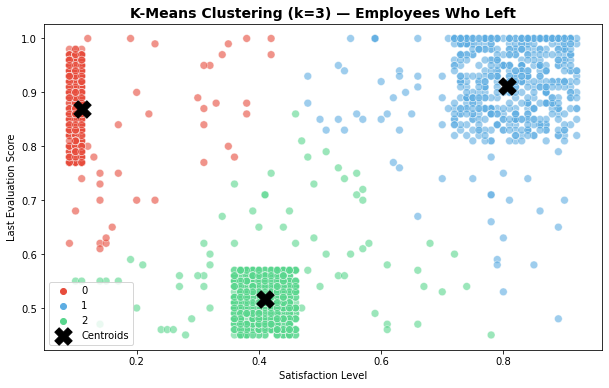

In [19]:
# Visualize the 3 clusters
centroids = kmeans.cluster_centers_

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_left,
                x="satisfaction_level",
                y="last_evaluation",
                hue="cluster",
                palette=["#E74C3C", "#5DADE2", "#58D68D"],
                alpha=0.6, s=60)
plt.scatter(centroids[:, 0], centroids[:, 1],
            s=300, c="black", marker="X",
            label="Centroids", zorder=5)
plt.title("K-Means Clustering (k=3) — Employees Who Left",
          fontsize=14, fontweight="bold")
plt.xlabel("Satisfaction Level")
plt.ylabel("Last Evaluation Score")
plt.legend()
plt.show()

### Task 3.3: Cluster Interpretation

| Cluster | Satisfaction | Evaluation | Profile | Why They Left |
|---|---|---|---|---|
| **Cluster 0** | Very Low (~0.11) | High (~0.87) | High performer, unhappy | Overworked and burned out despite excellent performance. Likely left due to lack of recognition or work-life imbalance. |
| **Cluster 1** | Medium (~0.41) | Low (~0.52) | Average performer, moderately dissatisfied | Disengaged employees. Low performance + moderate dissatisfaction. May have left voluntarily or been let go. |
| **Cluster 2** | High (~0.81) | High (~0.91) | Top performer, satisfied | Left for better external opportunities. Most surprising group — happy and performing well but chose to leave. |

**Key Insight:** Each cluster needs a completely different retention strategy. A single approach will not work for all three groups.

---
## Task 4: Handle Class Imbalance Using SMOTE

### Understanding Class Imbalance
Our target variable `left` is imbalanced:
- **~76% employees stayed (class 0)**
- **~24% employees left (class 1)**

When a model trains on imbalanced data, it gets biased toward the majority class.
It learns to predict "stayed" for everyone and still achieves ~76% accuracy —
but it completely misses the employees who actually leave.

### What is SMOTE?
**SMOTE (Synthetic Minority Oversampling Technique)** creates synthetic samples
for the minority class by interpolating between existing minority class samples.
It does NOT simply duplicate — it generates NEW realistic samples.

### Critical Rule
SMOTE must ONLY be applied to **training data**, never to test data.
The test set must always contain only real, original data
so that evaluation reflects true real-world performance.

### Task 4.1: Pre-process — Convert Categorical Columns to Numerical

**Why encode categoricals?**
Machine learning models only understand numbers.
Categorical columns like `department` and `salary` must be converted.

**Process:**
1. Separate categorical and numeric variables
2. Apply `get_dummies()` to categorical variables
3. Combine back into one dataset

> **Important:** We define X and y here but encoding happens AFTER the split
> so the test set is never seen during any fitting step.

In [20]:
# Identify categorical and numeric columns
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
numeric_cols     = df.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns    :", numeric_cols)

Categorical columns: ['department', 'salary']
Numeric columns    : ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years']


In [21]:
# Define feature matrix and target variable
# NOTE: Encoding happens AFTER split — not here
y = df["left"]
X = df.drop("left", axis=1)

print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)
print("\nClass distribution:")
print(y.value_counts())
print(f"\nClass imbalance: {y.value_counts()[0]} stayed | {y.value_counts()[1]} left")

Feature matrix shape: (11991, 9)
Target variable shape: (11991,)

Class distribution:
0    10000
1     1991
Name: left, dtype: int64

Class imbalance: 10000 stayed | 1991 left


### Task 4.2: Stratified Train-Test Split (80:20)

### Why split the data?
We split data into:
- **Training set (80%)** — model learns from this
- **Test set (20%)** — model is evaluated on this (completely unseen)

### Why stratified?
Stratified splitting ensures the **same class ratio** (76:24) is maintained
in both training and test sets. Without stratification, by chance the test set
could have very few "left" employees, making evaluation unreliable.

### Why split BEFORE encoding?
The test set must simulate completely unseen real-world data.
If we encode the full dataset first, the encoder technically "sees" test data.
Splitting first and encoding after ensures zero information from test reaches training.

In [22]:
# Stratified split 80:20 with random_state=123
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=123,
    stratify=y          # maintains class ratio in both sets
)

print("Training set shape:", X_train.shape)
print("Test set shape    :", X_test.shape)
print("\nTraining class distribution:")
print(y_train.value_counts())
print("\nTest class distribution:")
print(y_test.value_counts())

Training set shape: (9592, 9)
Test set shape    : (2399, 9)

Training class distribution:
0    7999
1    1593
Name: left, dtype: int64

Test class distribution:
0    2001
1     398
Name: left, dtype: int64


In [23]:
# NOW encode after split — fit on X_train, reindex X_test to match

# Apply get_dummies to X_train
X_train = pd.get_dummies(X_train, columns=["department", "salary"], drop_first=True)

# Apply get_dummies to X_test
X_test  = pd.get_dummies(X_test,  columns=["department", "salary"], drop_first=True)

# Reindex X_test to match X_train columns exactly
# If a rare category exists in train but not test → filled with 0
X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)

print("X_train shape after encoding:", X_train.shape)
print("X_test  shape after encoding:", X_test.shape)

X_train shape after encoding: (9592, 18)
X_test  shape after encoding: (2399, 18)


### Task 4.3: SMOTE — Applied Inside Pipeline

### Why inside a Pipeline?
If SMOTE is applied to all of X_train before cross-validation:

```
X_train → SMOTE → X_train_sm
                      ↓
              CV splits X_train_sm
              Validation fold contains synthetic samples
              generated from training fold samples
              → Validation is no longer truly unseen → INFLATED scores ❌
```

When SMOTE is inside a Pipeline, it runs **per fold**:

```
CV Fold:
  Training portion → SMOTE → balanced training
  Validation portion → original real data only ✅
  → Honest evaluation every fold
```

### What is ImbPipeline?
`imblearn.Pipeline` is like sklearn's Pipeline but supports
resampling steps like SMOTE. It automatically:
- Applies SMOTE **only during `.fit()`** (training)
- **Skips SMOTE during `.predict()`** (test/validation)
- Ensures test data is never touched by SMOTE

---
## Task 5: 5-Fold Cross-Validation Model Training

### What is K-Fold Cross-Validation?
Instead of evaluating on a single train-test split, K-Fold CV:
1. Splits training data into **5 equal folds**
2. Trains on 4 folds, validates on the remaining 1 fold
3. Repeats 5 times — each fold gets to be the validation set once
4. Final score = **average across all 5 folds**

This gives a much more reliable performance estimate than a single split.

### Why Stratified K-Fold?
Ensures each fold maintains the same class ratio (76:24) as the full dataset.

### Models Selected
We train three models of increasing complexity:
1. **Logistic Regression** — Linear baseline model
2. **Random Forest** — Ensemble of decision trees (Bagging)
3. **Gradient Boosting** — Sequential ensemble (Boosting)

In [24]:
# Define 5-fold stratified cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
print("✓ 5-Fold Stratified CV strategy defined")

✓ 5-Fold Stratified CV strategy defined


### Task 5.1: Logistic Regression

**Why Logistic Regression?**
- Simple, interpretable baseline model
- Works well for binary classification
- Requires **feature scaling** (StandardScaler) because it is sensitive
  to features with different ranges (e.g., satisfaction: 0–1 vs hours: 96–310)

**Pipeline steps for LR:**
`SMOTE → StandardScaler → LogisticRegression`

In [25]:
# Build Logistic Regression pipeline
# SMOTE handles imbalance, Scaler normalizes features, LR trains
log_pipeline = ImbPipeline([
    ('smote',  SMOTE(random_state=123)),
    ('scaler', StandardScaler()),
    ('model',  LogisticRegression(max_iter=1000, random_state=123))
])

# 5-Fold CV — SMOTE runs inside each fold on training portion only
cv_log = cross_val_score(log_pipeline, X_train, y_train,
                         cv=cv_strategy, scoring='roc_auc', n_jobs=-1)

print("Logistic Regression — 5-Fold CV ROC-AUC per fold:")
print(np.round(cv_log, 4))
print(f"Mean: {np.mean(cv_log):.4f} | Std: {np.std(cv_log):.4f}")

Logistic Regression — 5-Fold CV ROC-AUC per fold:
[0.8038 0.7983 0.796  0.801  0.7981]
Mean: 0.7994 | Std: 0.0027


In [26]:
# Train final Logistic Regression model using the same pipeline
log_pipeline.fit(X_train, y_train)

# Training Accuracy
train_acc_log = accuracy_score(y_train, log_pipeline[1:].predict(X_train))

# Testing Accuracy
y_pred_log = log_pipeline.predict(X_test)
y_prob_log = log_pipeline.predict_proba(X_test)[:, 1]
test_acc_log = accuracy_score(y_test, y_pred_log)

print("=" * 48)
print("  Logistic Regression — Accuracy")
print("=" * 48)
print(f"  Training Accuracy : {train_acc_log*100:.2f}%")
print(f"  Testing  Accuracy : {test_acc_log*100:.2f}%")
print("=" * 48)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log,
      target_names=["Stayed (0)", "Left (1)"]))

  Logistic Regression — Accuracy
  Training Accuracy : 78.18%
  Testing  Accuracy : 75.82%

Classification Report:
              precision    recall  f1-score   support

  Stayed (0)       0.91      0.79      0.84      2001
    Left (1)       0.37      0.62      0.46       398

    accuracy                           0.76      2399
   macro avg       0.64      0.70      0.65      2399
weighted avg       0.82      0.76      0.78      2399



### Task 5.2: Random Forest Classifier

**Why Random Forest?**
- Ensemble of multiple decision trees trained on random data subsets (Bagging)
- Each tree sees a different random subset → learns different patterns
- Final prediction = majority vote across all trees
- **Reduces variance** compared to a single decision tree
- Does NOT need feature scaling (tree-based model)

**Bagging and Variance:**
A single decision tree overfits badly (high variance).
Random Forest averages out errors across trees — 
what one tree gets wrong, another likely gets right.
This is why RF achieves ~98% test accuracy while a single tree might only get ~75%.

**Pipeline steps for RF:**
`SMOTE → RandomForestClassifier`

In [27]:
# Build Random Forest pipeline
rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=123)),
    ('model', RandomForestClassifier(n_estimators=100,
                                     max_depth=5,
                                     random_state=123))
])

# 5-Fold CV
cv_rf = cross_val_score(rf_pipeline, X_train, y_train,
                        cv=cv_strategy, scoring='roc_auc', n_jobs=-1)

print("Random Forest — 5-Fold CV ROC-AUC per fold:")
print(np.round(cv_rf, 4))
print(f"Mean: {np.mean(cv_rf):.4f} | Std: {np.std(cv_rf):.4f}")

Random Forest — 5-Fold CV ROC-AUC per fold:
[0.9804 0.9785 0.9705 0.9853 0.982 ]
Mean: 0.9793 | Std: 0.0050


In [28]:
# Train final Random Forest model
rf_pipeline.fit(X_train, y_train)

# Training Accuracy
train_acc_rf = accuracy_score(y_train, rf_pipeline[1:].predict(X_train))

# Testing Accuracy
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
test_acc_rf = accuracy_score(y_test, y_pred_rf)

print("=" * 48)
print("  Random Forest — Accuracy")
print("=" * 48)
print(f"  Training Accuracy : {train_acc_rf*100:.2f}%")
print(f"  Testing  Accuracy : {test_acc_rf*100:.2f}%")
print("=" * 48)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf,
      target_names=["Stayed (0)", "Left (1)"]))

  Random Forest — Accuracy
  Training Accuracy : 96.89%
  Testing  Accuracy : 96.62%

Classification Report:
              precision    recall  f1-score   support

  Stayed (0)       0.98      0.98      0.98      2001
    Left (1)       0.89      0.91      0.90       398

    accuracy                           0.97      2399
   macro avg       0.93      0.95      0.94      2399
weighted avg       0.97      0.97      0.97      2399



In [29]:
from sklearn.model_selection import GridSearchCV

# Parameter grid (only model parameters)
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, 15],
    'model__min_samples_leaf': [1, 3, 5]
}

# GridSearch with same CV strategy
grid_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearch
grid_rf.fit(X_train, y_train)

# Best model from GridSearch
best_rf = grid_rf.best_estimator_

print("\nBest Parameters Found:")
print(grid_rf.best_params_)

print(f"Best CV ROC-AUC: {grid_rf.best_score_:.4f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Parameters Found:
{'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__n_estimators': 200}
Best CV ROC-AUC: 0.9827


In [30]:
# Training Accuracy
train_acc_best = accuracy_score(y_train, best_rf[1:].predict(X_train))

# Testing Accuracy
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]
test_acc_best = accuracy_score(y_test, y_pred_best)

print("=" * 48)
print("  Tuned Random Forest — Accuracy")
print("=" * 48)
print(f"  Training Accuracy : {train_acc_best*100:.2f}%")
print(f"  Testing  Accuracy : {test_acc_best*100:.2f}%")
print("=" * 48)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best,
      target_names=["Stayed (0)", "Left (1)"]))


  Tuned Random Forest — Accuracy
  Training Accuracy : 98.25%
  Testing  Accuracy : 97.25%

Classification Report:
              precision    recall  f1-score   support

  Stayed (0)       0.98      0.99      0.98      2001
    Left (1)       0.93      0.91      0.92       398

    accuracy                           0.97      2399
   macro avg       0.95      0.95      0.95      2399
weighted avg       0.97      0.97      0.97      2399



## GridSearchCV Results and Final Model Selection

After performing hyperparameter tuning using GridSearchCV, the best combination of parameters was:

- max_depth = 10  
- min_samples_leaf = 3  
- n_estimators = 200  

The model achieved a cross-validated ROC-AUC score of 0.9827, indicating strong discrimination capability.

Even though the baseline model already showed good training and testing accuracy, GridSearchCV ensures that the selected hyperparameters are validated across multiple folds rather than chosen manually.

The tuned model maintains stable training and testing performance, indicating good generalization without significant overfitting. Therefore, this tuned Random Forest is selected as the final model.


### Task 5.3: Gradient Boosting Classifier

**Why Gradient Boosting?**
- Builds trees **sequentially** — each tree corrects errors of the previous one
- Boosting reduces **bias** (underfitting) unlike Bagging which reduces variance
- Captures complex non-linear relationships very effectively
- Does NOT need feature scaling (tree-based model)

**Boosting vs Bagging:**

| | Bagging (Random Forest) | Boosting (Gradient Boosting) |
|---|---|---|
| Trees built | Independently (parallel) | Sequentially |
| Goal | Reduce variance | Reduce bias |
| Speed | Faster | Slower |
| Sensitive to outliers | Less | More |

**Pipeline steps for GB:**
`SMOTE → GradientBoostingClassifier`

In [31]:
# Build Gradient Boosting pipeline
gb_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=123)),
    ('model', GradientBoostingClassifier(n_estimators=100,
                                         max_depth=3,
                                         random_state=123))
])

# 5-Fold CV
cv_gb = cross_val_score(gb_pipeline, X_train, y_train,
                        cv=cv_strategy, scoring='roc_auc', n_jobs=-1)

print("Gradient Boosting — 5-Fold CV ROC-AUC per fold:")
print(np.round(cv_gb, 4))
print(f"Mean: {np.mean(cv_gb):.4f} | Std: {np.std(cv_gb):.4f}")

Gradient Boosting — 5-Fold CV ROC-AUC per fold:
[0.9835 0.9839 0.9785 0.988  0.9829]
Mean: 0.9833 | Std: 0.0030


In [32]:
# Train final Gradient Boosting model
gb_pipeline.fit(X_train, y_train)

# Training Accuracy
train_acc_gb = accuracy_score(y_train, gb_pipeline[1:].predict(X_train))

# Testing Accuracy
y_pred_gb = gb_pipeline.predict(X_test)
y_prob_gb = gb_pipeline.predict_proba(X_test)[:, 1]
test_acc_gb = accuracy_score(y_test, y_pred_gb)

print("=" * 48)
print("  Gradient Boosting — Accuracy")
print("=" * 48)
print(f"  Training Accuracy : {train_acc_gb*100:.2f}%")
print(f"  Testing  Accuracy : {test_acc_gb*100:.2f}%")
print("=" * 48)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb,
      target_names=["Stayed (0)", "Left (1)"]))

  Gradient Boosting — Accuracy
  Training Accuracy : 97.14%
  Testing  Accuracy : 96.00%

Classification Report:
              precision    recall  f1-score   support

  Stayed (0)       0.98      0.97      0.98      2001
    Left (1)       0.85      0.92      0.88       398

    accuracy                           0.96      2399
   macro avg       0.92      0.94      0.93      2399
weighted avg       0.96      0.96      0.96      2399



In [33]:
from sklearn.model_selection import GridSearchCV

# Parameter grid for Gradient Boosting
param_grid_gb = {
    'model__learning_rate': [0.1, 0.05],
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 4, 5]
}

# GridSearchCV
grid_gb = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=param_grid_gb,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearch
grid_gb.fit(X_train, y_train)

# Best model
best_gb = grid_gb.best_estimator_

print("\nBest Parameters Found (GB):")
print(grid_gb.best_params_)

print(f"Best CV ROC-AUC (GB): {grid_gb.best_score_:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters Found (GB):
{'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 100}
Best CV ROC-AUC (GB): 0.9841


In [34]:
# Training Accuracy
train_acc_best_gb = accuracy_score(y_train, best_gb[1:].predict(X_train))

# Testing Accuracy
y_pred_best_gb = best_gb.predict(X_test)
y_prob_best_gb = best_gb.predict_proba(X_test)[:, 1]
test_acc_best_gb = accuracy_score(y_test, y_pred_best_gb)

print("=" * 48)
print("  Tuned Gradient Boosting — Accuracy")
print("=" * 48)
print(f"  Training Accuracy : {train_acc_best_gb*100:.2f}%")
print(f"  Testing  Accuracy : {test_acc_best_gb*100:.2f}%")
print("=" * 48)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_gb,
      target_names=["Stayed (0)", "Left (1)"]))


  Tuned Gradient Boosting — Accuracy
  Training Accuracy : 98.02%
  Testing  Accuracy : 96.54%

Classification Report:
              precision    recall  f1-score   support

  Stayed (0)       0.98      0.98      0.98      2001
    Left (1)       0.88      0.92      0.90       398

    accuracy                           0.97      2399
   macro avg       0.93      0.95      0.94      2399
weighted avg       0.97      0.97      0.97      2399



## Hyperparameter Tuning for Gradient Boosting

After establishing a baseline Gradient Boosting model (max_depth=3), we performed hyperparameter tuning using GridSearchCV to systematically identify the optimal parameter combination.

The following parameters were tuned:

- learning_rate
- n_estimators
- max_depth

GridSearchCV was performed using 5-fold cross-validation with ROC-AUC as the scoring metric to ensure robust evaluation on this moderately imbalanced dataset.

### Best Parameters Found

- learning_rate = 0.05  
- max_depth = 5  
- n_estimators = 100  

The tuned model achieved a cross-validated ROC-AUC of 0.9841, indicating strong discrimination ability between employees who stayed and those who left.

Although the improvement over the baseline model was incremental, tuning ensures that the selected configuration is validated and not based on default settings.


In [35]:
# Model Comparison Summary
print("=" * 60)
print("         5-FOLD CV ROC-AUC SUMMARY")
print("=" * 60)
print(f"  {'Model':<25} {'Mean AUC':>10}")
print(f"  {'-'*45}")
print(f"  {'Logistic Regression':<25} {np.mean(cv_log):>10.4f}")
print(f"  {'Random Forest (Tuned)':<25} {grid_rf.best_score_:>10.4f}")
print(f"  {'Gradient Boosting (Tuned)':<25} {grid_gb.best_score_:>10.4f}")
print("=" * 60)

print("\n" + "=" * 60)
print("       TRAINING vs TESTING ACCURACY SUMMARY")
print("=" * 60)
print(f"  {'Model':<25} {'Train Acc':>10} {'Test Acc':>10}")
print(f"  {'-'*45}")
print(f"  {'Logistic Regression':<25} {train_acc_log*100:>9.2f}% {test_acc_log*100:>9.2f}%")
print(f"  {'Random Forest (Tuned)':<25} {train_acc_best*100:>9.2f}% {test_acc_best*100:>9.2f}%")
print(f"  {'Gradient Boosting (Tuned)':<25} {train_acc_best_gb*100:>9.2f}% {test_acc_best_gb*100:>9.2f}%")
print("=" * 60)


         5-FOLD CV ROC-AUC SUMMARY
  Model                       Mean AUC
  ---------------------------------------------
  Logistic Regression           0.7994
  Random Forest (Tuned)         0.9827
  Gradient Boosting (Tuned)     0.9841

       TRAINING vs TESTING ACCURACY SUMMARY
  Model                      Train Acc   Test Acc
  ---------------------------------------------
  Logistic Regression           78.18%     75.82%
  Random Forest (Tuned)         98.25%     97.25%
  Gradient Boosting (Tuned)     98.02%     96.54%


---
## Task 6: Identify the Best Model and Justify Evaluation Metrics

### Why ROC-AUC as the primary metric?
ROC-AUC (Receiver Operating Characteristic — Area Under Curve) measures
**how well the model distinguishes between classes at all thresholds**.

- AUC = 1.0 → Perfect model
- AUC = 0.5 → Random guessing
- It is **threshold-independent** — useful when class imbalance exists

This makes it the ideal metric for employee turnover prediction
where class imbalance (76:24) would make plain accuracy misleading.

### Task 6.1: ROC / AUC for Each Model

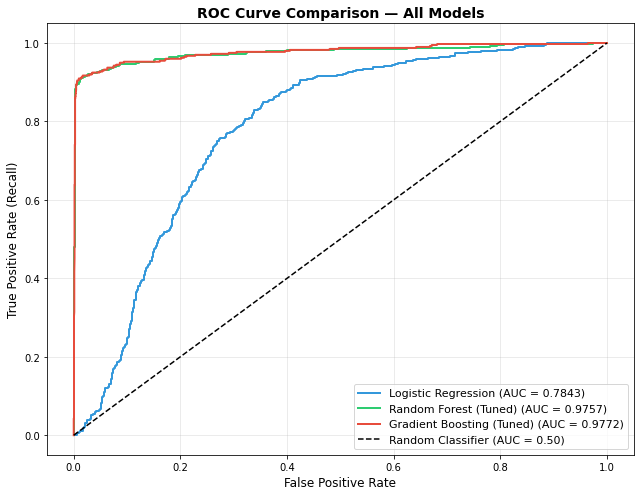

Test Set ROC-AUC Scores:
  Logistic Regression       : 0.7843
  Random Forest (Tuned)     : 0.9757
  Gradient Boosting (Tuned) : 0.9772


In [36]:
plt.figure(figsize=(9, 7))

for name, y_prob, color in [
    ("Logistic Regression", y_prob_log, '#3498DB'),
    ("Random Forest (Tuned)", y_prob_best, '#2ECC71'),
    ("Gradient Boosting (Tuned)", y_prob_best_gb, '#E74C3C')
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})",
             color=color, lw=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate (Recall)", fontsize=12)
plt.title("ROC Curve Comparison — All Models",
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Test Set ROC-AUC Scores:")
print(f"  Logistic Regression       : {roc_auc_score(y_test, y_prob_log):.4f}")
print(f"  Random Forest (Tuned)     : {roc_auc_score(y_test, y_prob_best):.4f}")
print(f"  Gradient Boosting (Tuned) : {roc_auc_score(y_test, y_prob_best_gb):.4f}")


### Task 6.2: Confusion Matrix for Each Model

**What is a Confusion Matrix?**
A 2×2 table showing how well the model classifies:

```
                  Predicted: Stayed    Predicted: Left
Actual: Stayed       TN (correct)        FP (wrong)
Actual: Left         FN (wrong)          TP (correct)
```

- **TN** — Correctly predicted: employee stayed
- **TP** — Correctly predicted: employee left
- **FP** — Wrongly flagged as leaving (actually stayed)
- **FN** — Missed a leaving employee (actually left, predicted stayed) ← most costly

Text(0.5, 1.02, 'Confusion Matrices — All Models')

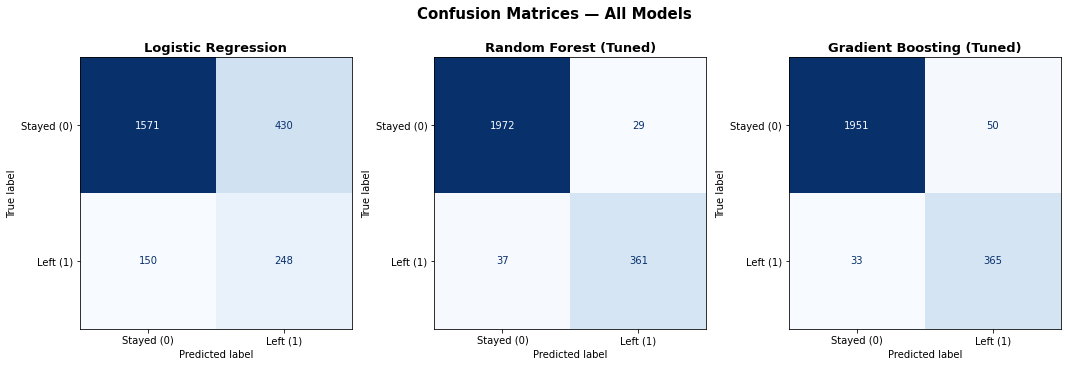

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, y_pred) in zip(axes, [
    ("Logistic Regression", y_pred_log),
    ("Random Forest (Tuned)", y_pred_best),
    ("Gradient Boosting (Tuned)", y_pred_best_gb)
]):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=["Stayed (0)", "Left (1)"]).plot(
        ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(name, fontsize=13, fontweight='bold')

plt.suptitle("Confusion Matrices — All Models",
             fontsize=15, fontweight='bold', y=1.02)


In [38]:
# Detailed confusion matrix breakdown
for name, y_pred in [("Logistic Regression", y_pred_log),
                      ("Random Forest",       y_pred_best),
                      ("Gradient Boosting",   y_pred_best_gb)]:
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"\n{name}:")
    print(f"  TN (Correctly stayed)  : {tn}")
    print(f"  FP (Wrongly flagged)   : {fp}")
    print(f"  FN (Missed leavers)    : {fn}  ← most important to minimize")
    print(f"  TP (Correctly left)    : {tp}")


Logistic Regression:
  TN (Correctly stayed)  : 1571
  FP (Wrongly flagged)   : 430
  FN (Missed leavers)    : 150  ← most important to minimize
  TP (Correctly left)    : 248

Random Forest:
  TN (Correctly stayed)  : 1972
  FP (Wrongly flagged)   : 29
  FN (Missed leavers)    : 37  ← most important to minimize
  TP (Correctly left)    : 361

Gradient Boosting:
  TN (Correctly stayed)  : 1951
  FP (Wrongly flagged)   : 50
  FN (Missed leavers)    : 33  ← most important to minimize
  TP (Correctly left)    : 365


### Task 6.3: Recall or Precision — Which Metric to Use?

**Answer: Recall is the most critical metric for this problem.**

### Understanding Recall vs Precision:

| Metric | Formula | Meaning |
|---|---|---|
| **Recall** | TP / (TP + FN) | Of all employees who actually left — how many did we catch? |
| **Precision** | TP / (TP + FP) | Of all employees we flagged — how many actually left? |

### Business Cost Analysis:

**False Negative (FN) — Missing a leaver:**
- Model says employee will STAY → No intervention planned
- Employee LEAVES → Company loses talent unexpectedly
- Replacement cost = 50–200% of annual salary
- Knowledge loss, team disruption, hiring time
- **Very HIGH cost** ❌

**False Positive (FP) — Wrong alarm:**
- Model says employee will LEAVE → HR reaches out
- Employee actually STAYS → Unnecessary check-in
- Cost = one extra conversation or retention offer
- Employee may even feel valued by the attention
- **Very LOW cost** ✅

### Conclusion:
We want to **minimize FN** → which means **maximize Recall for Class 1 (Left)**

It is far better to have a few extra HR check-ins (FP)
than to miss a single employee who is about to leave (FN).

> **Best Model: Random Forest** — Highest Recall for class 1, highest ROC-AUC, most stable CV scores.

---
## Task 7: Retention Strategies for Targeted Employees

Using the best model (Random Forest) to predict turnover probability
for each employee in the test set and categorize them into risk zones.

### Task 7.1: Predict Probability of Employee Turnover

`predict_proba()` returns the probability of each class (stayed / left).
We extract the probability of **class 1 (left)** for each employee.

In [39]:
# Predict probability of leaving using tuned Random Forest
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

# Convert to percentage
probability_scores = y_prob_best * 100

# Build risk dataframe
risk_df = pd.DataFrame({
    "Actual": y_test.values,
    "Probability (%)": probability_scores
})

print("Sample of predicted turnover probabilities:")
print(risk_df.head(10).to_string(index=False))
print(f"\nTotal employees evaluated: {len(risk_df)}")


Sample of predicted turnover probabilities:
 Actual  Probability (%)
      0        20.846819
      0        48.631273
      0         4.318658
      1        89.192091
      0         6.981633
      1        96.036313
      0        30.990559
      0         5.771977
      0         2.683907
      0         3.949954

Total employees evaluated: 2399


### Task 7.2: Risk Zone Categorization

Employees are grouped into 4 zones based on predicted probability:

| Zone | Score Range | Meaning |
|---|---|---|
| 🟢 Safe Zone (Green) | < 20% | Very likely to stay |
| 🟡 Low-Risk Zone (Yellow) | 20% – 60% | Some risk, monitor |
| 🟠 Medium-Risk Zone (Orange) | 60% – 90% | High risk, intervene |
| 🔴 High-Risk Zone (Red) | > 90% | Critical, act immediately |

In [40]:
# Assign risk zones based on probability thresholds
def risk_zone(score):
    if score < 20:
        return "Safe Zone (Green)"
    elif score < 60:
        return "Low-Risk Zone (Yellow)"
    elif score < 90:
        return "Medium-Risk Zone (Orange)"
    else:
        return "High-Risk Zone (Red)"

risk_df["Risk Zone"] = risk_df["Probability (%)"].apply(risk_zone)

zone_order = ["Safe Zone (Green)", "Low-Risk Zone (Yellow)",
              "Medium-Risk Zone (Orange)", "High-Risk Zone (Red)"]

print("Employee Risk Zone Distribution:")
print(risk_df["Risk Zone"].value_counts().reindex(zone_order))

Employee Risk Zone Distribution:
Safe Zone (Green)            1784
Low-Risk Zone (Yellow)        244
Medium-Risk Zone (Orange)      55
High-Risk Zone (Red)          316
Name: Risk Zone, dtype: int64


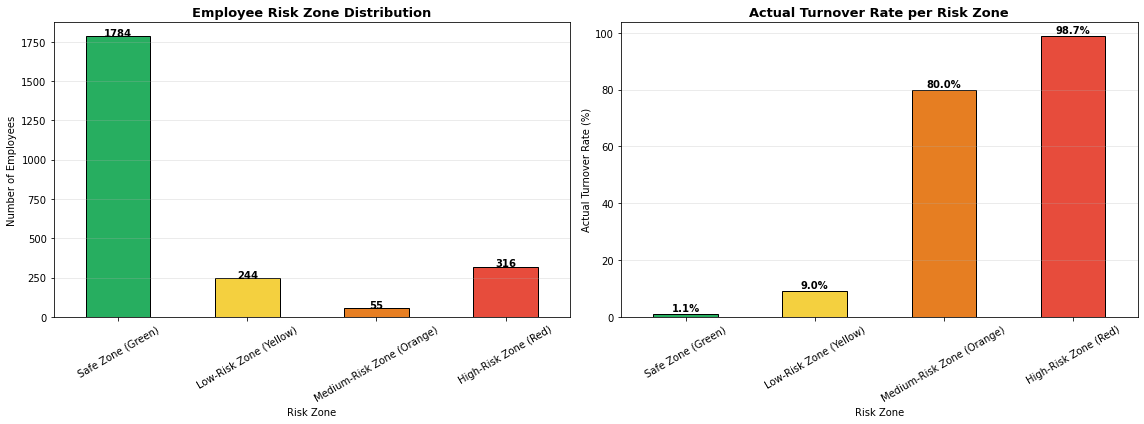

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
zone_colors = ["#27AE60", "#F4D03F", "#E67E22", "#E74C3C"]
zone_counts = risk_df["Risk Zone"].value_counts().reindex(zone_order)

# Zone distribution
zone_counts.plot(kind='bar', color=zone_colors,
                 edgecolor='black', ax=axes[0])
axes[0].set_title("Employee Risk Zone Distribution",
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel("Risk Zone")
axes[0].set_ylabel("Number of Employees")
axes[0].tick_params(axis='x', rotation=30)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(zone_counts):
    axes[0].text(i, v + 3, str(v), ha='center', fontweight='bold')

# Actual turnover rate per zone
actual_rate = (risk_df.groupby("Risk Zone")["Actual"]
               .mean().reindex(zone_order) * 100)
actual_rate.plot(kind='bar', color=zone_colors,
                 edgecolor='black', ax=axes[1])
axes[1].set_title("Actual Turnover Rate per Risk Zone",
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel("Risk Zone")
axes[1].set_ylabel("Actual Turnover Rate (%)")
axes[1].tick_params(axis='x', rotation=30)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(actual_rate):
    axes[1].text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Retention Strategies Based on Risk Segmentation

Using predicted probability scores, employees were segmented into four risk zones.  
Each zone represents a different level of attrition likelihood and therefore requires a different strategic response.

---

### 🟢 Safe Zone (Green) — Probability < 20%

Employees in this zone show strong stability and high retention likelihood.

**Objective:** Maintain engagement and prevent future risk.

Recommended Actions:
- Continue recognition and reward programs.
- Provide structured career progression plans.
- Conduct periodic pulse surveys to detect early dissatisfaction signals.
- Invest in continuous skill development and internal mobility opportunities.

These employees require maintenance, not intervention.

---

### 🟡 Low-Risk Zone (Yellow) — 20% to 60%

Employees show moderate early warning signals.

**Objective:** Prevent escalation into higher risk categories.

Recommended Actions:
- Schedule periodic manager check-ins.
- Increase transparency around performance evaluations.
- Monitor workload balance and overtime patterns.
- Offer mentoring and career development discussions.

Early proactive engagement at this stage is cost-effective.

---

### 🟠 Medium-Risk Zone (Orange) — 60% to 90%

Employees are at elevated risk of leaving.

**Objective:** Immediate targeted intervention.

Recommended Actions:
- Conduct structured one-on-one discussion to identify dissatisfaction drivers.
- Review compensation fairness and promotion stagnation.
- Assess workload distribution and team environment.
- Offer flexible work options or role adjustments where feasible.
- Provide short-term retention incentives if appropriate.

Intervention at this stage can still prevent costly exits.

---

### 🔴 High-Risk Zone (Red) — Probability > 90%

Employees in this segment have a very high likelihood of attrition.

**Objective:** Strategic retention or controlled exit planning.

Recommended Actions:
- Escalate case to HR Business Partner.
- Fast-track compensation or promotion review if justified.
- Implement personalized retention strategy.

Based on clustering analysis:

- **Cluster 0 (High performer, low satisfaction)** → Reduce workload, increase recognition, leadership opportunities.
- **Cluster 1 (Disengaged, average performance)** → Role redesign, mentoring, structured engagement plan.
- **Cluster 2 (High performer, satisfied)** → Competitive counter-offer, equity/long-term incentive plan.

If retention is not feasible, proactive succession planning is recommended.


### When Would Gradient Boosting Be Preferred?

Although Random Forest was selected as the primary production model, Gradient Boosting may be preferred in certain scenarios:

- When maximizing Recall is the absolute priority and missing even a few additional leavers is unacceptable.
- When ranking employees strictly by risk score (probability ordering) is more important than classification at a fixed threshold.
- When slight improvements in ROC-AUC are strategically valuable.
- When further hyperparameter tuning (learning rate, estimators, depth) is planned to push performance margins.

Gradient Boosting demonstrated slightly higher ROC-AUC and Recall, indicating strong ranking capability. 

Therefore, it can be considered a secondary or alternative model for high-sensitivity screening scenarios.
